# Brexit: analiza sentymentu

Pytania do rozważenia:
1. Czy jest związek między przynależnością do partii politycznej a sentymentem wypowiedzi?
2. Jaki sentyment wypowiedzi jest dominujący dla głównych partii politycznych?
3. Wypowiedzi których z polityków odstają od linii partii, do której przynależą?
4. Jak zmieniał się sentyment w czasie?

## 1. Pozyskanie danych

Dane zostały pobrane ze strony: https://hansard.parliament.uk/, która zawiera zapisy debat parlamentarnych. Do pozyskania danych użyto narzędzia ParseHub (https://www.parsehub.com/), za pomocą którego z każdej debaty (do 17.01.2019 r. włącznie) wyekstrahowano wypowiedzi polityków, odnośniki do ich profili i informacje o debacie (nazwa, data). Dane o politykach, ze względu na ograniczenie liczby zapytań dla bezpłatnej wersji ParseHuba, pobrano za pomocą osobnego skryptu w języku Python, który pozwolił na znalezienie informacji o polityku (imię i nazwisko, partia polityczna) z adresu URL zawierającego jego profil:

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

def getdata(url):
    r = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data, features = "html.parser")
    h2s = soup.find(lambda elm: elm.name == "h2")
    name = ''
    party = ''
    try:
        for h2 in h2s:
            name = h2.a.text.strip()
            div = h2.find_next('div')
            party = div.find_next('strong').text.strip()
    except:
        print(url)
    return name, party

df = pd.read_csv('debates.csv')
df1 = pd.DataFrame(columns = ['url', 'name', 'party'])

urls = df.debate_politician_url.unique()
print(len(urls))
for url in urls:
    name, party = getdata(url)
    row = [url, name, party]
    print(row, len(df1))
    df1.loc[len(df1)] = row
df1.to_csv('names.csv', index=False)

Dane o politykach (plik 'names.csv') złączono z danymi o debatach ('debates.csv') za pomocą osobnego skryptu, otrzymując w wyniku plik 'merged.csv':

In [ ]:
import pandas as pd

df = pd.read_csv('debates.csv')
df1 = pd.read_csv('names.csv')
df = df.merge(df1, left_on='debate_politician_url', right_on='url', how='outer')
df.to_csv('merged.csv')

In [5]:
import pandas as pd

df = pd.read_csv('merged.csv')
df.sample(5) # losowe 5 rzędów z pliku

,debate_name,debate_date,speech,name,party
11365,Farming: Impact of Brexit,21 July 2016,We know that there is great global demand for ...,Lord Gardiner of Kimble,Conservative
8929,Brexit: Deal or No Deal (European Union Commit...,16 January 2018,"Leaving with no deal will not be a disaster, a...",Baroness Deech,Crossbench
6783,Brexit and the EU Budget (EUC Report),6 April 2017,“The long-term ghastliness of the legal compli...,Lord Young of Cookham,Conservative
9760,Brexit: UK Nationals,9 January 2019,To ask Her Majesty’s Government what outreach ...,Baroness Miller of Chilthorne Domer,Liberal Democrat
11176,Brexit: Food Security,23 October 2018,I am always interested in any material the nob...,Lord Gardiner of Kimble,Conservative


In [2]:
df.shape

(21536, 5)

W pliku znajduje się 21536 wypowiedzi.

## 2. Analiza tonu wypowiedzi

Do analizy tonu wypowiedzi użyto API udostępnionego przez IBM (Tone Analyzer: https://cloud.ibm.com/apidocs/tone-analyzer). Każdej wypowiedzi przypisano jedną z 6 emocji: Confident, Tentative, Fear, Anger, Joy, Sadness. Ze zbioru 7 głównych emocji, które wykrywa Tone Analyzer, usunięto Analytical, ponieważ wstępne testy pokazały, że większość wypowiedzi jest zaliczana do tej kategorii. Jeżeli dana wypowiedź została przypisana do więcej niż 1 emocji, wybierano główną, czyli tę, dla której wynik ("score") był najwyższy. Jeżeli żadna emocja nie została przypisana, wypowiedź nie była brana pod uwagę w dalszej analizie. Do analizy użyto poniższego skryptu:

In [ ]:
from watson_developer_cloud import ToneAnalyzerV3
import json
import pandas as pd

tone_analyzer = ToneAnalyzerV3(
    version='2019-01-26',
    iam_apikey='gUyh2OR0IBixeyvJWRfs_QjOdDGphIDi2ZhpbsmAg_aE',
    url='https://gateway-lon.watsonplatform.net/tone-analyzer/api'
)
tone_analyzer.set_default_headers({'x-watson-learning-opt-out': "true"})

def analyze_sentiment(text):
    tone_analysis = tone_analyzer.tone(
        {'text': text},
        'application/json'
    ).get_result()

    tones = tone_analysis['document_tone']['tones']
    tones_sorted = sorted(tones, key=lambda k: k['score'], reverse=True)
    main_tone = ''
    main_tone_score = 0
    if len(tones_sorted):
        main = tones_sorted[0]
        if main['tone_name'] != 'Analytical':
            main_tone = main['tone_name']
            main_tone_score = main['score']
        else:
            try:
                if tones_sorted[1]['tone_name'] != 'Analytical':
                    main_tone = tones_sorted[1]['tone_name']
                    main_tone_score = tones_sorted[1]['score']
            except:
                pass
    return main_tone, main_tone_score

df = pd.read_csv('merged.csv')
df1 = pd.DataFrame(columns = ['debate', 'date', 'speech', 'name', 'party', 'sentiment', 'score'])
for index, row in df.iterrows():
    try:
        sentiment, score = analyze_sentiment(row['speech'])
        if score!=0:
            row = [row['debate_name'], row['debate_date'], row['speech'], row['name'], row['party'], sentiment, score]
            df1.loc[len(df1)] = row
    except:
        pass

df1.to_csv('sentiment.csv')

Dane z dołączoną kolumną z wynikiem analizy zapisano w pliku 'sentiment.csv'.

In [11]:
df = pd.read_csv('sentiment.csv')
df.sample(5) # losowe 5 rzędów

,debate,date,speech,name,party,sentiment,score
12609,Brexit and Foreign Affairs,26 June 2017,It is also good to see so many new Members pre...,Emily Thornberry,Labour,Joy,0.808592
1109,Brexit: UK-Irish Relations,5 September 2017,"In our UK-Irish relations report, we outlined ...",Lord Jay of Ewelme,Crossbench,Confident,0.703461
6863,Brexit: Withdrawal Agreement and Political Dec...,14 January 2019,"Why do the Government not, even at this late s...",Baroness Miller of Chilthorne Domer,Liberal Democrat,Tentative,0.754524
14680,Brexit Negotiations,11 December 2017,I wish the Prime Minister every success in neg...,John Redwood,Conservative,Confident,0.802229
4128,Brexit: Trade in Non-financial Services (EUC R...,18 December 2017,"Secondly, the experience challenged the conven...",Lord Liddle,Labour,Joy,0.930359


In [12]:
df.shape

(15486, 7)

W ten sposób uzyskano 15486 wypowiedzi z przypisanym tonem.

Każdej z przenanalizowanych wypowiedzi poza kategorią (główną emocją) przypisano wartość liczbową z zakresu od -1 (najbardziej negatywna) do 1 (najbardziej pozytywna). Do przypisania wartości liczbowych do wypowiedzi użyto VADERa (https://github.com/cjhutto/vaderSentiment), słownika i narzędzia dostępnego w bibliotece NLTK. 

In [15]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Zdefiniowano następującą funkcję, która pozwoliła na przypisanie wartości do wypowiedzi:

In [18]:
def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score['compound']

Przykładowe wyniki działania funkcji:

In [30]:
nltk_sentiment('i love data science') # pozytywna wypowiedź

0.6369

In [29]:
nltk_sentiment('drugs are bad') # negatywna wypowiedź

-0.5423

In [28]:
nltk_sentiment('i am hungry') # neutralna wypowiedź

0.0

In [27]:
t = df.sample(1) # przykładowa wypowiedź z pliku
print(t['speech'].values, nltk_sentiment(t['speech'].values[0]))

['“David Davis was a terrible Brexit Secretary. He could hardly be bothered to go to Brussels and rapidly lost respect there”.'] -0.5141


Wyniki analizy sentymentu za pomocą VADERa zapisano w kolumnie "sentiment_simple":

In [32]:
df['sentiment_simple'] = 0
for index, row in df.iterrows():
    df['sentiment_simple'].iloc[index] = nltk_sentiment(row['speech'])

/home/ekot/.local/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Wyniki zapisano w pliku 'sentiment_ext.csv'.

In [33]:
df.to_csv('sentiment_ext.csv')

In [49]:
df.sample(5) # 5 przykładowych rzędów

,debate,date,speech,name,party,sentiment,score,sentiment_simple
12038,Brexit: Negotiations and No-deal Contingency P...,4 September 2018,"My Lords, the Minister’s Statement today says ...",Lord Berkeley,Labour,Tentative,0.680970,-0.4939
9723,Brexit: Sectoral Impact Assessments,7 November 2017,"My Lords, I am sure that we will all be reassu...",Lord Cormack,Conservative,Confident,0.757777,0.5434
1638,Brexit: Proposed UK–EU Security Treaty (Europe...,16 January 2019,He spoke also about Galileo.,Lord Bilimoria,Crossbench,Tentative,0.822231,0.0000
2770,Brexit: UK-EU Relations (EUC Report),2 July 2018,Yesterday Graham Brady warned that a divided p...,Baroness Hayter of Kentish Town,Labour,Confident,0.688430,0.9758
10541,"Brexit: Justice for Families, Individuals and ...",20 December 2017,"I apologise for interrupting, but I did not in...",Baroness Shackleton of Belgravia,Conservative,Confident,0.869578,0.6369


### 2.1. Analiza sentymentu partii

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
df = pd.read_csv('sentiment_ext.csv')
df = df[['debate', 'date', 'speech', 'name', 'party', 'sentiment', 'sentiment_simple']]
df.sample(5)

,debate,date,speech,name,party,sentiment,sentiment_simple
7960,Brexit: Farm Support,6 November 2017,"My Lords, the noble Lord is absolutely right. ...",Lord Gardiner of Kimble,Conservative,Confident,0.9545
4114,Arts: Impact of Brexit,11 October 2018,"My Lords, it is a great pleasure to support my...",Lord Liddle,Labour,Tentative,0.9571
14738,Brexit: Constitutional Reform and Governance A...,8 September 2016,Does the Minister believe that it is possible ...,Lord Myners,Crossbench,Tentative,-0.0516
2084,Brexit: Preparations and Negotiations,23 July 2018,"However, I must add a note of warning on one p...",Lord Hope of Craighead,Crossbench,Confident,0.5098
7391,Brexit: Article 50,7 November 2016,I will absolutely answer the first point by sa...,Lord Bridges of Headley,Conservative,Confident,0.8624


W celu powiązania sentymentu z latami, z daty wyekstrahowano rok:

In [25]:
df['year'] = df['date'].apply(lambda x: str(x)[-5:])

In [26]:
df.head()

,debate,date,speech,name,party,sentiment,sentiment_simple,year
0,Brexit: Withdrawal Agreement and Political Dec...,10 January 2019,"—after we leave the European Union, I would ha...",Lord Strathclyde,Conservative,Tentative,0.2579,2019
1,Brexit: Withdrawal Agreement and Political Dec...,10 January 2019,"For me, the key lies with the backstop—an issu...",Lord Strathclyde,Conservative,Fear,-0.0297,2019
2,Brexit: Withdrawal Agreement and Political Dec...,10 January 2019,"I thank the House for its warm welcome, though...",Lord Strathclyde,Conservative,Joy,0.9287,2019
3,Brexit: Withdrawal Agreement and Political Dec...,10 January 2019,This is the political challenge facing the Com...,Lord Strathclyde,Conservative,Tentative,0.8338,2019
4,Brexit: Withdrawal Agreement and Political Dec...,10 January 2019,"Whatever views you have on Brexit, this stage ...",Lord Strathclyde,Conservative,Joy,0.9488,2019


W zbiorze znaleziono wypowiedzi polityków z następujących partii politycznych:

In [27]:
df.party.unique()

array(['Conservative', 'Crossbench', 'Liberal Democrat', 'Labour',
       'Democratic Unionist Party', 'UK Independence Party', 'Bishops',
       'Plaid Cymru', 'Non-affiliated', 'Independent Social Democrat',
       'Scottish National Party', 'Labour Independent', 'Green Party',
       'Labour (Co-op)', 'Social Democratic & Labour Party', 'Speaker',
       'Independent', nan, 'Ulster Unionist Party', 'Independent Labour',
       'Independent Ulster Unionist'], dtype=object)

In [75]:
dfs={}
parties = df.party.unique()
parties_clean = [x for x in parties if str(x) != 'nan']
for s in parties_clean:
    dfs['{}'.format(s)] = df[df['party'] == s]

dfs.keys()

dict_keys(['Independent', 'Plaid Cymru', 'Scottish National Party', 'Independent Labour', 'Bishops', 'Democratic Unionist Party', 'Ulster Unionist Party', 'Labour', 'Conservative', 'Labour (Co-op)', 'Non-affiliated', 'Speaker', 'Independent Ulster Unionist', 'Green Party', 'Crossbench', 'Independent Social Democrat', 'Labour Independent', 'Liberal Democrat', 'Social Democratic & Labour Party', 'UK Independence Party'])

Dla każdej z partii znaleziono średni sentyment na podstawie wartości w kolumnie 'sentiment_simple'.

In [96]:
def plot_sentiment():
    vals = {}
    for party in dfs.keys():
        prob = dfs[party]['sentiment_simple'].mean()
        vals[party] = prob
    sorted_by_val = sorted(vals.items(), key=lambda kv: kv[1])
    plt.scatter([i[0] for i in sorted_by_val], [i[1] for i in sorted_by_val])
    plt.xticks([])
    print([i[0] for i in sorted_by_val])

    plt.show()

['Independent Ulster Unionist', 'Independent Labour', 'Green Party', 'Independent', 'Scottish National Party', 'Independent Social Democrat', 'Plaid Cymru', 'Labour (Co-op)', 'Labour Independent', 'Speaker', 'Bishops', 'Crossbench', 'Labour', 'Liberal Democrat', 'UK Independence Party', 'Ulster Unionist Party', 'Social Democratic & Labour Party', 'Non-affiliated', 'Democratic Unionist Party', 'Conservative']


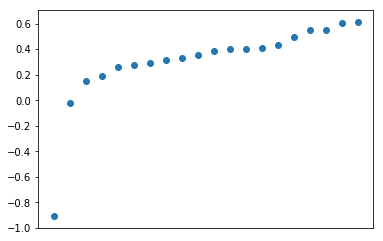

In [97]:
plot_sentiment()

Wartość 'Independent Ulster Unionist' została zakwalifikowna jako partia i jej politycy mają bardzo niską, odstającą wartość sentymentu. Ta wartość w kolumnie określającej partię powinna dotyczyć tylko kilku polityków, więc tak skrajny wynik może być tym spowodowany. 

In [107]:
df[df.party == 'Independent Ulster Unionist']

,debate,date,speech,name,party,sentiment,sentiment_simple,year
15422,Brexit: Northern Cyprus,14 September 2017,"My Lords, I suppose that I should by now be us...",Lord Maginnis of Drumglass,Independent Ulster Unionist,Anger,-0.9081,2017


Jak widać ten skrajnie niski sentyment dotyczył tylko jednej wypowiedzi jednego polityka. Wykres bez uwzględnionej tej wypowiedzi wygląda następująco:

In [104]:
def plot_sentiment():
    vals = {}
    for party in dfs.keys():
        prob = dfs[party]['sentiment_simple'].mean()
        vals[party] = prob
    sorted_by_val = sorted(vals.items(), key=lambda kv: kv[1])[1:]
    plt.scatter([i[0] for i in sorted_by_val], [i[1] for i in sorted_by_val])
    plt.xticks([])
    print(sorted_by_val)

    plt.show()

[('Independent Labour', -0.021019999999999994), ('Green Party', 0.15130697674418608), ('Independent', 0.1891875), ('Scottish National Party', 0.2615), ('Independent Social Democrat', 0.2732833333333334), ('Plaid Cymru', 0.2922673267326733), ('Labour (Co-op)', 0.3122295454545454), ('Labour Independent', 0.33159999999999995), ('Speaker', 0.3513769230769231), ('Bishops', 0.3825094202898551), ('Crossbench', 0.39718785008237234), ('Labour', 0.39850670698185814), ('Liberal Democrat', 0.4096958717610892), ('UK Independence Party', 0.43173333333333325), ('Ulster Unionist Party', 0.49604545454545446), ('Social Democratic & Labour Party', 0.5467076923076923), ('Non-affiliated', 0.5477256140350877), ('Democratic Unionist Party', 0.6054191919191919), ('Conservative', 0.6126453357591797)]


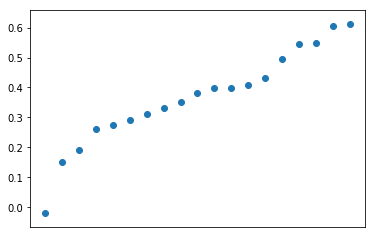

In [105]:
plot_sentiment()

Średnie wartości sentymentu wahają się od ok. 0 do ok. 0.6. Najniższy średni sentyment uzyskano dla polityków, dla których wartość w kolumnie 'party' to 'Independent Labour'. Dotyczy to jedynie 2 polityków.

In [108]:
df[df.party == 'Independent Labour']

,debate,date,speech,name,party,sentiment,sentiment_simple,year
15301,Brexit: Article 50,29 October 2018,"Is it not helpful for the noble Lord, Lord Pea...",Lord Stoddart of Swindon,Independent Labour,Confident,-0.3252,2018
15302,Brexit: Economic Analysis of Various Scenarios,28 November 2018,"My Lords, does the Minister agree that the for...",Lord Stoddart of Swindon,Independent Labour,Tentative,0.3094,2018
15315,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,It is also clear that the UK’s exit from the E...,Lord Truscott,Independent Labour,Tentative,0.9246,2018
15316,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,It is not overdramatic to say that this countr...,Lord Truscott,Independent Labour,Sadness,-0.9825,2018
15317,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,"My Lords, it is a pleasure to follow the noble...",Lord Truscott,Independent Labour,Joy,0.8481,2018
15318,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,"The Brexit negotiations have been a shambles, ...",Lord Truscott,Independent Labour,Tentative,-0.2023,2018
15319,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,The British people voted leave in the referend...,Lord Truscott,Independent Labour,Sadness,-0.9479,2018
15320,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,The political declaration is in my view meanin...,Lord Truscott,Independent Labour,Tentative,-0.2732,2018
15321,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,The question for your Lordships’ House and Her...,Lord Truscott,Independent Labour,Sadness,-0.5245,2018
15322,Brexit: Withdrawal Agreement and Political Dec...,5 December 2018,We need time as a Parliament and as a country ...,Lord Truscott,Independent Labour,Tentative,0.9633,2018


Partią polityczną, która ma najniższy średni sentyment jest Partia Zielonych (ok. 0.15). Najwyższy średni sentyment ma Partia Konserwatywna.

Na wykresie poniżej przedstawiono, ile wypowiedzi należy do każdej ze znalezionych partii:

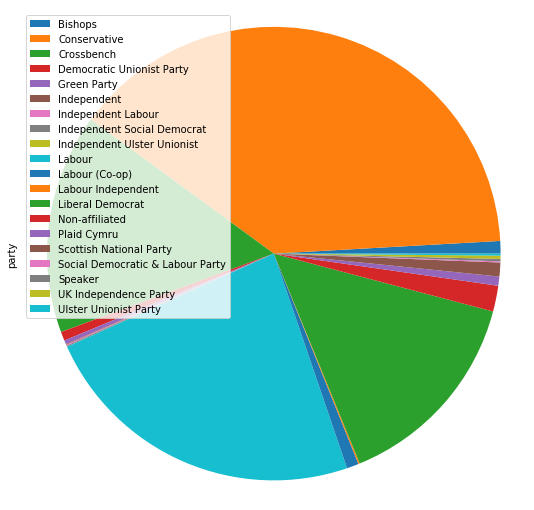

In [13]:
counts = df.party.groupby(df.party).count()
counts.plot(kind='pie', figsize=(9,9), labels=None)
plt.legend(labels=counts.index, loc="best")
plt.axis('equal')
plt.show()

4 grupy polityczne, które odnotowały największą liczbę wypowiedzi, to: Conservative (Partia Konserwatywna), Labour (Partia Pracy), Liberal Democrat (Liberalni Demokraci), Crossbench (bezpartyjni). W dalszej analizie rozważane będą te 4 grupy.

In [11]:
main_parties = ['Conservative', 'Labour', 'Crossbench', 'Liberal Democrat']
df1 = df.loc[df['party'].isin(main_parties)]

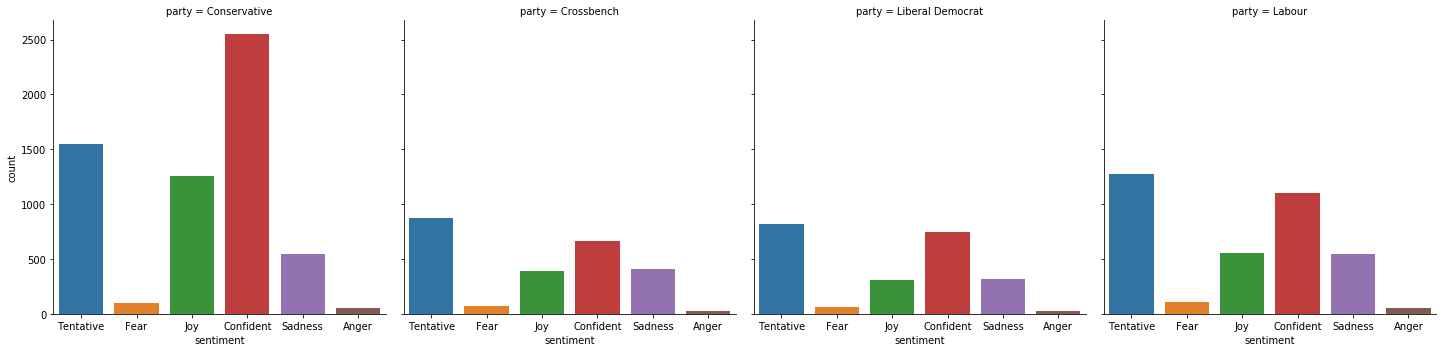

In [12]:
sns.catplot(x="sentiment", kind="count", col="party", data=df1)

Dla 3 z 4 grup (poza Partią Konserwatywną) dominującą w wypowiedziach emocją jest Tentative (niepewność). Emocją dominującą w wypowiedziach Partii Konserwatywnej jest Confident (pewność). Jedynie dla Partii Konserwatywnej zaobserwowano większą liczbę wypowiedzi z emocją Joy (radość) niż z emocją Sadness (smutek). 

In [352]:
df1.groupby(['party', 'sentiment'])['sentiment'].count()

party             sentiment
Conservative      Anger          50
                  Confident    2548
                  Fear           97
                  Joy          1253
                  Sadness       549
                  Tentative    1549
Crossbench        Anger          24
                  Confident     666
                  Fear           67
                  Joy           393
                  Sadness       408
                  Tentative     870
Labour            Anger          49
                  Confident    1105
                  Fear          105
                  Joy           556
                  Sadness       547
                  Tentative    1276
Liberal Democrat  Anger          29
                  Confident     742
                  Fear           62
                  Joy           307
                  Sadness       321
                  Tentative     816
Name: sentiment, dtype: int64

In [16]:
parties_sentiment = df1.groupby(['party', 'sentiment'])['sentiment'].count()
print(parties_sentiment)

party             sentiment
Conservative      Anger          50
                  Confident    2548
                  Fear           97
                  Joy          1253
                  Sadness       549
                  Tentative    1549
Crossbench        Anger          24
                  Confident     666
                  Fear           67
                  Joy           393
                  Sadness       408
                  Tentative     870
Labour            Anger          49
                  Confident    1105
                  Fear          105
                  Joy           556
                  Sadness       547
                  Tentative    1276
Liberal Democrat  Anger          29
                  Confident     742
                  Fear           62
                  Joy           307
                  Sadness       321
                  Tentative     816
Name: sentiment, dtype: int64


Dla każdej z grup obliczono 2 stosunki porównywalnych emocji: Joy do Sadness ("js") i Confident do Tentative ("ct").

In [17]:
parties_js = []
parties_ct = []
for i in range(24):
    if i%6 == 1:
        parties_ct.append(parties_sentiment[i]/parties_sentiment[i+4])
    elif i%6 == 3:
        parties_js.append(parties_sentiment[i]/parties_sentiment[i+1])

In [18]:
main_parties

['Conservative', 'Labour', 'Crossbench', 'Liberal Democrat']

In [19]:
parties_ct

[1.644932214331827, 0.7655172413793103, 0.8659874608150471, 0.9093137254901961]

In [20]:
parties_js

[2.2823315118397085, 0.9632352941176471, 1.016453382084095, 0.956386292834891]

In [21]:
party_data_js = dict(zip(main_parties, parties_js))
party_data_ct = dict(zip(main_parties, parties_ct))

In [22]:
party_data_js

{'Conservative': 2.2823315118397085,
 'Crossbench': 1.016453382084095,
 'Labour': 0.9632352941176471,
 'Liberal Democrat': 0.956386292834891}

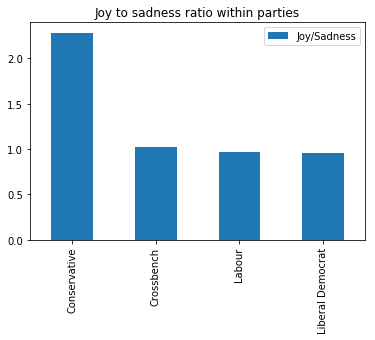

In [23]:
pd.DataFrame(party_data_js, index=['Joy/Sadness']).T.plot(kind='bar', title = 'Joy to sadness ratio within parties')

Dla Partii Konserwatywnej wartość stosunku Joy/Sadness jest ponad 2 razy wyższa dla jego wartości dla kolejnej grupy. Stosunek Joy/Sadness w pozostałych 3 grupach jest do siebie zbliżony.

In [25]:
party_data_ct

{'Conservative': 1.644932214331827,
 'Crossbench': 0.8659874608150471,
 'Labour': 0.7655172413793103,
 'Liberal Democrat': 0.9093137254901961}

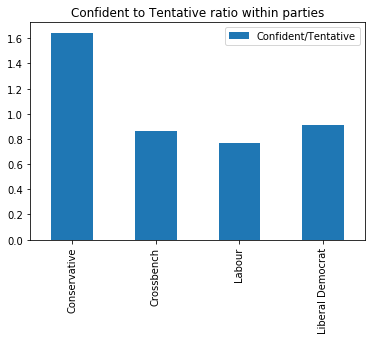

In [26]:
pd.DataFrame(party_data_ct, index=['Confident/Tentative']).T.plot(kind='bar', title = 'Confident to Tentative ratio within parties')

Także w przypadku stosunku Confident/Tentative jego wartość dla Partii Konserwatywnej jest wyższa niż dla pozostałych 3 grup.

### 2.2. Analiza sentymentu polityków

Dla wypowiedzi każdego z polityków w zbiorze określono stosunki Joy/Sadness i Confident/Tentative. Jeżeli dla danego polityka nie znaleziono wypowiedzi zawierających emocji Sadness i wypowiedzi zawierających emocji Tentative (dzielenie przez 0), nie brano go pod uwagę.

In [33]:
df2 = df1[df1['name'].isin(df1['name'].value_counts().index)]

In [34]:
grp = df2.groupby(['name', 'party'])

In [35]:
len(grp)

624

W zbiorze (przed znalezieniem stosunków) jest 624 polityków.

In [36]:
politicians = {}
for i in grp:
    emotions = list(i[1]['sentiment'].values)
    try:
        ct = emotions.count('Confident')/emotions.count('Tentative')
        js = emotions.count('Joy')/emotions.count('Sadness')
        politicians[i[0]] = (ct, js)
    except:
        print("not all emotions needed found for", i[0][0])

not all emotions needed found for Adam Afriyie
not all emotions needed found for Alex Burghart
not all emotions needed found for Alex Chalk
not all emotions needed found for Alex Cunningham
not all emotions needed found for Alison McGovern
not all emotions needed found for Andrew Bowie
not all emotions needed found for Andrew Bridgen
not all emotions needed found for Andrew Rosindell
not all emotions needed found for Andy Slaughter
not all emotions needed found for Anna McMorrin
not all emotions needed found for Baroness Afshar
not all emotions needed found for Baroness Bakewell of Hardington Mandeville
not all emotions needed found for Baroness Barker
not all emotions needed found for Baroness Barran
not all emotions needed found for Baroness Bowles of Berkhamsted
not all emotions needed found for Baroness Boycott
not all emotions needed found for Baroness Bryan of Partick
not all emotions needed found for Baroness Burt of Solihull
not all emotions needed found for Baroness Buscombe
n

In [37]:
len(politicians)

377

Po znalezieniu stosunków pozostało 377 polityków. 

In [48]:
df3 = pd.DataFrame(columns=['name', 'party', 'ct_ratio', 'js_ratio'])
for key, value in politicians.items():
    name = key[0]
    party = key[1]
    ct_ratio = value[0]
    js_ratio = value[1]
    row = [name, party, ct_ratio, js_ratio]
    df3.loc[len(df3)] = row
df3.head() # pierwsze 5 rzędów nowego zbioru

,name,party,ct_ratio,js_ratio
0,Lord Davies of Stamford,Labour,0.788462,0.913043
1,Baroness Anelay of St Johns,Conservative,3.038462,4.875000
2,Lord German,Liberal Democrat,0.933333,1.333333
3,Lord Tomlinson,Labour,0.500000,4.000000
4,Baroness Ludford,Liberal Democrat,1.056911,0.674419


Dane ze zbioru (df3) przedstawiono na wykresie:

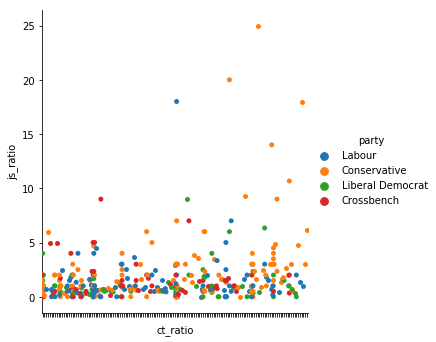

In [49]:
g = sns.catplot(x="ct_ratio", y="js_ratio", hue="party", kind="swarm", data=df3)
g.set(xticklabels=[])

Z wykresu można odczytać, że dla większości polityków stosunek Joy/Sadness ma niską wartość, poza kilkoma politykami z Partii Konserwatywnej i jednym z Partii Pracy. Można zauważyć, że dla polityków z Partii Konserwatywnej, dla których stosunek Joy/Sadness jest wysoki, wysoki jest również stosunek Confident/Tentative. Można wnioskować, że ta grupa polityków jest zadowolona z Brexitu i pewna jego pozytywnego wpływu.

In [50]:
df3[df3.party == 'Labour'].sort_values(by = 'js_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio
298,Lord Bragg,Labour,1.0,18.0


W Partii Pracy to Lord Bragg jest politykiem, dla którego stosunek Joy/Sadness jest wysoki i odstaje od pozostałych polityków jego ugrupowania.

Zdecydowano się przeprowadzić analizę dla najbardziej znaczących dla Brexitu polityków (którzy mają co najmniej 100 wypowiedzi), żeby znaleźć polityków odstających od linii partii.

Funkcja zdefiniowana poniżej pozwala znaleźć stosunki Joy/Sadness, Confident/Tentative, a także średnią wartość sentymentu (z VADERa, z kolumny "sentiment_simple") dla polityków, którzy mają od n_min do n_max wypowiedzi.

In [40]:
def get_politicians(n_low, n_high):
    dfp = df1[df1['name'].isin(df1['name'].value_counts()[df1['name'].value_counts()>=n_low][df1['name'].value_counts()<n_high].index)]
    grp = dfp.groupby(['name', 'party'])
    politicians = {}
    for i in grp:
        emotions = list(i[1]['sentiment'].values)
        simple = i[1]['sentiment_simple'].values
        try:
            ct = emotions.count('Confident')/emotions.count('Tentative')
            js = emotions.count('Joy')/emotions.count('Sadness')
            politicians[i[0]] = (ct, js, simple.mean())
        except:
            print("not all emotions needed found for", i[0][0])
    dft = pd.DataFrame(columns=['name', 'party', 'ct_ratio', 'js_ratio', 'simple'])
    for key, value in politicians.items():
        name = key[0]
        party = key[1]
        ct_ratio = value[0]
        js_ratio = value[1]
        simple = value[2]
        row = [name, party, ct_ratio, js_ratio, simple]
        dft.loc[len(dft)] = row
    g = sns.catplot(x="ct_ratio", y="js_ratio", hue="party", kind="swarm", data=dft)
    g.set(xticklabels=[])
    return dft

Na wykresie poniżej przedstawiono stosunki Joy/Sadness i Confident/Tentative dla polityków, którzy mają co najmniej 100 wypowiedzi:

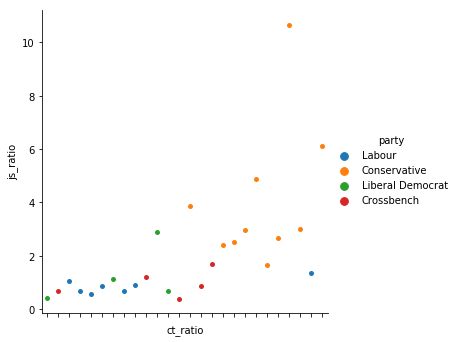

In [41]:
df3 = get_politicians(100,len(df1))

Można zauważyć 3 punkty odstające: 1 z Partii Pracy (wysoki stosunek Confident/Tentative), 1 z Liberalnych Demokratów i 1 z bezpartyjnych (wysoki stosunek Joy/Sadness).

In [779]:
df3[df3.party == 'Labour'].sort_values(by = 'ct_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio,simple
14,Lord Judd,Labour,5.583333,1.357143,0.558197


Punktem odstającym z Partii Pracy jest Lord Judd.

In [42]:
df3[df3.party == 'Labour'].sort_values(by = 'js_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio,simple
11,Lord Judd,Labour,5.583333,1.357143,0.558197


Jest to także polityk, dla którego stosunek Joy/Sadness wśród najbardziej znaczących polityków Partii Pracy jest najwyższy.

In [780]:
df3[df3.party == 'Liberal Democrat'].sort_values(by = 'js_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio,simple
19,Lord Teverson,Liberal Democrat,0.977273,2.909091,0.629307


In [781]:
df3[df3.party == 'Crossbench'].sort_values(by = 'js_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio,simple
5,The Earl of Kinnoull,Crossbench,1.515152,1.692308,0.55329


Lord Teverson (Liberalni Demokraci) i Earl of Kinnoull (bezpartyjni) to najbardziej zadowoleni z Brexitu przedstawiciele swoich ugrupowań w grupie polityków, którzy mają co najmniej 100 wypowiedzi.

In [782]:
df3[df3.party == 'Conservative']

,name,party,ct_ratio,js_ratio,simple
0,Baroness Evans of Bowes Park,Conservative,4.111111,3.000000,0.743087
2,Baroness Anelay of St Johns,Conservative,3.038462,4.875000,0.754193
4,Lord Bridges of Headley,Conservative,3.454545,1.666667,0.676250
6,Baroness Williams of Trafford,Conservative,2.235294,2.500000,0.646203
7,Lord Henley,Conservative,4.000000,10.666667,0.828196
10,Baroness Goldie,Conservative,3.640000,2.666667,0.835838
11,Lord Keen of Elie,Conservative,1.127660,3.875000,0.674399
12,Lord Gardiner of Kimble,Conservative,8.333333,6.125000,0.863342
17,Lord Callanan,Conservative,2.725000,2.972222,0.666017
23,Lord O'Shaughnessy,Conservative,2.041667,2.416667,0.754251


Wśród polityków Partii Konserwatywnej Lord Henley i Lord Gardiner of Kimble są najbardziej wyróżniającymi się osobami (kolejno: najwyższy stosunkek Joy/Sadness i Confident/Tentative).

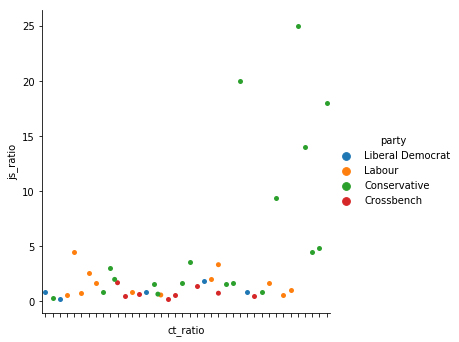

In [44]:
dft = get_politicians(50,100)

W grupie polityków, którzy mają od 50 do 99 wypowiedzi, jest 1 osoba z Partii Konserwatywnej, która ma bardzo niską wartość dla obu stosunków, jest to Baroness Wheatcroft:

In [45]:
dft[dft.party == 'Conservative'].sort_values(by = 'ct_ratio').head(1)

,name,party,ct_ratio,js_ratio,simple
34,Baroness Wheatcroft,Conservative,0.4375,0.333333,0.23841


Wśród polityków Partii Pracy z tej grupy 1 polityk (Lord Mendelsohn) ma wysoki stosunek Joy/Sadness i jednocześnie niski Confident/Tentative:

In [785]:
dft[dft.party == 'Labour'].sort_values(by = 'js_ratio', ascending = False).head(6)

,name,party,ct_ratio,js_ratio,simple
30,Lord Mendelsohn,Labour,0.526316,4.500000,0.581889
29,Lord Hunt of Chesterton,Labour,1.400000,3.333333,0.629633
20,Lord Adonis,Labour,0.680000,2.600000,0.197895
17,Lord Collins of Highbury,Labour,1.263158,2.000000,0.515651
1,Baroness Jones of Whitchurch,Labour,0.692308,1.714286,0.667305
23,Lord Kennedy of Southwark,Labour,1.823529,1.666667,0.554456


### 2.3. Zmiana sentymentu w czasie

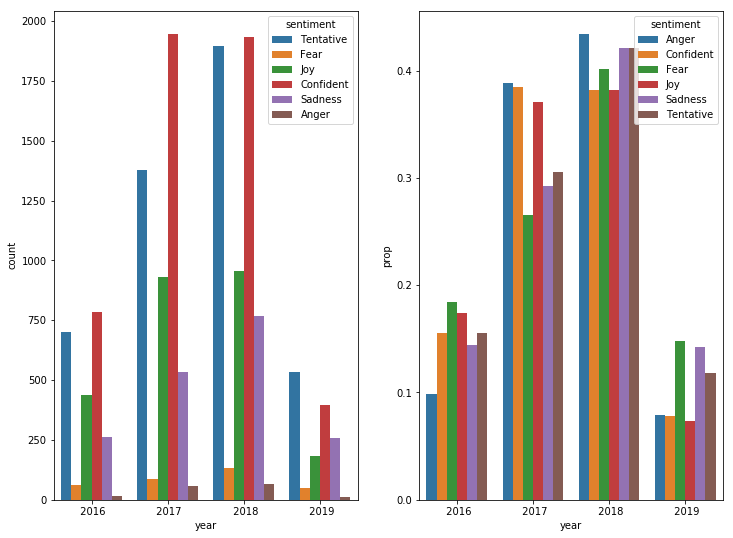

In [22]:
x, y, hue = "year", "prop", "sentiment"

f, axes = plt.subplots(1, 2, figsize=(12, 9))
sns.countplot(x=x, hue=hue, data=df1, ax=axes[0])

prop_df = (df1[x]
           .groupby(df1[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

W latach 2016-2018 było więcej wypowiedzi Confident (pewnych) niż Tentative (niepewnych). Można jednak zauważyć, że różnica liczby wypowiedzi Confident od liczby wypowiedzi Tentative znacznie się zmniejszyła w roku 2018 w porównaniu do roku 2017. W roku 2019 (początek roku) wypowiedzi Tentative jest więcej niż Confident. Analogiczne zachowanie można zaobserwować dla emocji Joy (radość) i Sadness (smutek). Różnica między nimi zmniejszyła się w 2018 roku, w 2019 liczba wypowiedzi z Sadness jako główną emocją jest wyższa od liczby wypowiedzi z Joy jako główną emocją.  

### 2.4. Analiza sentymentu z użyciem VADERa

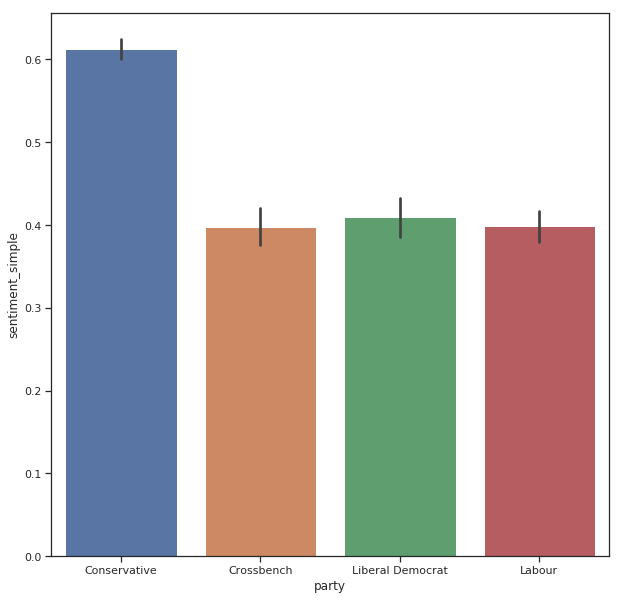

In [787]:
sns.barplot(x="party", y="sentiment_simple", data=df1)

Dla polityków Partii Konserwatywnej średni znaleziony sentyment (z możliwego zakresu od -1 do 1) jest wyższy niż w pozostałych 3 grupach.

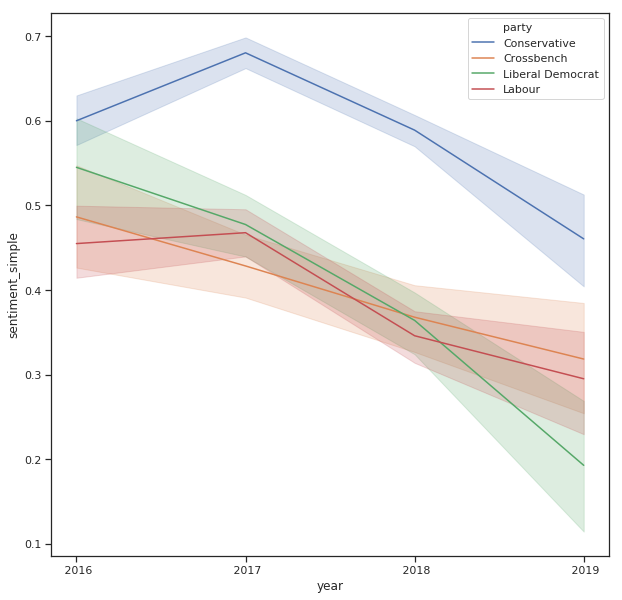

In [172]:
sns.lineplot(x='year', y='sentiment_simple', hue='party', data=df1)

W każdym roku wartość sentymentu dla Partii Konserwatywnej była wyższa niż jego wartość w pozostałych grupach. Od roku 2017 średnia wartość sentymentu spada w każdej z grup, także w Partii Konserwatywnej.

Średnią wartość sentymentu dodano jako 3 parametr (obok stosunków Joy/Sadness i Confident/Tentative) i przeanalizowano polityków, którzy mają co najmniej 50 wypowiedzi.

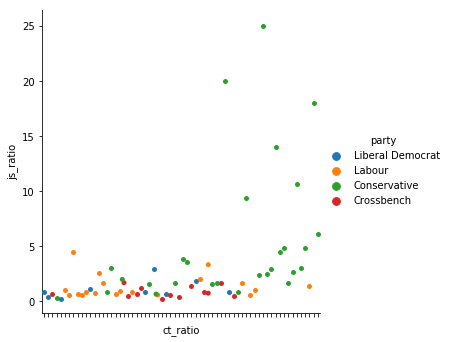

In [53]:
df3 = get_politicians(50,len(df1))

In [55]:
df3.party = pd.Categorical(df3.party)
df3['code'] = df3.party.cat.codes

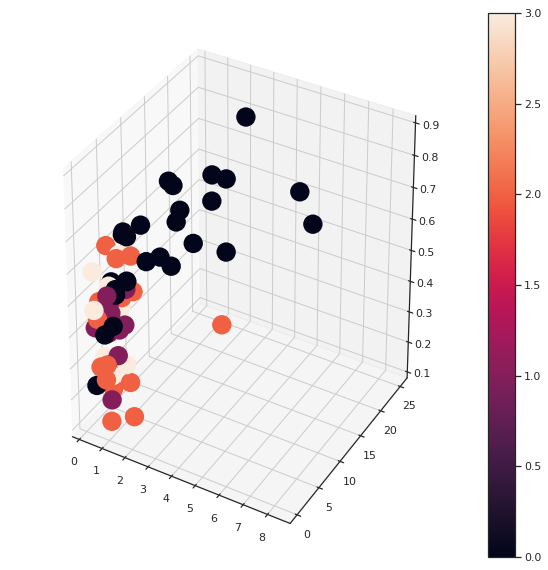

In [870]:
from mpl_toolkits.mplot3d import Axes3D

x = df3['ct_ratio'].values
y = df3['js_ratio'].values
z = df3['simple'].values
b2 = df3['code'].values
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
line = ax.scatter(x, y ,z , c=b2, s=1500, marker='.', edgecolors='none', depthshade=0)
cb = plt.colorbar(line)

3 polityków Partii Pracy ma odstającą (wysoką średnią wartość sentymentu):

In [57]:
df3[df3.party == 'Labour'].sort_values(by = 'simple', ascending = False).head(3)

,name,party,ct_ratio,js_ratio,simple,code
63,Baroness Jones of Whitchurch,Labour,0.692308,1.714286,0.667305,2
35,Lord Hunt of Chesterton,Labour,1.400000,3.333333,0.629633,2
2,Lord Mendelsohn,Labour,0.526316,4.500000,0.581889,2


In [66]:
df3[df3.party == 'Labour'].sort_values(by = 'ct_ratio', ascending = False).head(1)

,name,party,ct_ratio,js_ratio,simple,code
18,Lord Judd,Labour,5.583333,1.357143,0.558197,2


Wcześniej znaleziony Lord Judd, dla którego wartości stosunków Joy/Sadness i Confident/Tentative były wysokie, ma także dość wysoką średnią wartość sentymentu.

Jeden z polityków Partii Konserwatywnej znacznie odstaje od linii partii i wartości wszystkich 3 parametrów są dla niego niskie. Jest to wcześniej znaleziona Baroness Wheatcroft: 

In [63]:
df3[df3.party == 'Conservative'].sort_values(by = 'simple').head(1)

,name,party,ct_ratio,js_ratio,simple,code
59,Baroness Wheatcroft,Conservative,0.4375,0.333333,0.23841,0


Wśród Liberalnych Demokratów są 3 osoby, które mają wysoką średnią wartość sentymentu (wcześniej znaleziony Lord Teverson, Baroness Smith of Newnham i Baroness Falkner of Margravine, wartości pozostałych współczynników dla Baroness Smith of Newnham są jednak niskie):

In [874]:
df3[df3.party == 'Liberal Democrat'].sort_values(by = 'simple', ascending = False).head(5)

,name,party,ct_ratio,js_ratio,simple,code
8,Lord Teverson,Liberal Democrat,0.977273,2.909091,0.629307,3
25,Baroness Smith of Newnham,Liberal Democrat,0.359375,0.400000,0.596356,3
35,Baroness Falkner of Margravine,Liberal Democrat,0.948718,0.875000,0.560322,3
10,Baroness Miller of Chilthorne Domer,Liberal Democrat,1.250000,1.857143,0.487280,3
68,Lord Campbell of Pittenweem,Liberal Democrat,0.280000,0.888889,0.465892,3
19,Lord Shipley,Liberal Democrat,1.647059,0.888889,0.331030,3
2,Lord Wallace of Saltaire,Liberal Democrat,0.660714,1.125000,0.324561,3
55,Baroness Ludford,Liberal Democrat,1.056911,0.674419,0.282158,3


In [60]:
df3[df3.party == 'Conservative'].sort_values(by = 'simple', ascending = False).head(12)

,name,party,ct_ratio,js_ratio,simple,code
15,Lord Ahmad of Wimbledon,Conservative,3.000000,4.500000,0.868693,0
54,Lord Gardiner of Kimble,Conservative,8.333333,6.125000,0.863342,0
43,Baroness Goldie,Conservative,3.640000,2.666667,0.835838,0
53,Lord Henley,Conservative,4.000000,10.666667,0.828196,0
37,Viscount Younger of Leckie,Conservative,1.833333,9.333333,0.786789,0
66,Baroness Neville-Rolfe,Conservative,2.133333,25.000000,0.784395,0
65,Lord O'Shaughnessy,Conservative,2.041667,2.416667,0.754251,0
4,Baroness Anelay of St Johns,Conservative,3.038462,4.875000,0.754193,0
33,Baroness Evans of Bowes Park,Conservative,4.111111,3.000000,0.743087,0
19,Lord Ashton of Hyde,Conservative,5.714286,18.000000,0.729378,0


Możemy zauważyć, że wśród konserwatystów najwyższe znalezione wartości dla średniego sentymentu są dużo wyższe niż dla pozostałych grup. Wszystkie parametry mają wysokie wartości dla pierwszych 10 polityków z listy, możemy wnioskować, że są to najwięksi "entuzjaści" Brexitu.

## 3. Wnioski

Politycy Partii Konserwatywnej są grupą najbardziej entuzjastyczną wobec Brexitu. Od roku 2017 średnia wartość sentymentu spada w każdej z 4 głównych grup politycznych. Znaleziono polityków odstających od linii partii mierząc 3 parametry: liczbę wypowiedzi z wesołym tonem do liczby wypowiedzi z tonem smutnym, liczbę wypowiedzi z pewnym tonem do liczby wypowiedzi z tonem niepewnym i średnią watość sentymentu,